In [1]:
import torch
print(torch.cuda.is_available())		 # 查看GPu设备是否可用
print(torch.cuda.device_count()) 		# 查看GPu设备数量
print(torch.cuda.get_device_name())   	# 查看当前GPu设备名称，默认设备id从0开始
print(torch.cuda.current_device())		# 查看当前GPu设备id
torch.cuda.set_device(0)

True
1
NVIDIA GeForce RTX 3070 Ti Laptop GPU
0


In [2]:
import argparse
import os
import torch
from exp.exp_main import Exp_Main #exp stands for experiments
import random
import numpy as np
from utils.tools import dotdict
import pandas as pd
import matplotlib.pyplot as plt

fix_seed = 2021
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

parser = argparse.ArgumentParser(description='Autoformer & Transformer family for Time Series Forecasting')

# basic config
parser.add_argument('--is_training', type=int, required=True, default=1, help='status')
parser.add_argument('--model_id', type=str, required=True, default='test', help='model id')#模型id
parser.add_argument('--model', type=str, required=True, default='Autoformer',#选择模型
                    help='model name, options: [Autoformer, Informer, Transformer]')

# data loader
parser.add_argument('--data', type=str, required=True, default='ETTm1', help='dataset type')#数据类型；自己的数据用custom
parser.add_argument('--root_path', type=str, default='./data/ETT/', help='root path of the data file')#数据文件夹路径
parser.add_argument('--data_path', type=str, default='ETTh1.csv', help='data file')#具体文件
parser.add_argument('--features', type=str, default='M',
                    help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')#预测类别
parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')#OT好像代表Output Target, 在MS or S task下要预测的单变量
parser.add_argument('--freq', type=str, default='h',
                    help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='location of model checkpoints')#保存模型

# forecasting task
parser.add_argument('--seq_len', type=int, default=96, help='input sequence length')#输入序列长度
parser.add_argument('--label_len', type=int, default=48, help='start token length')#这个label_len一般设为seq_len/2用于提供近期的短期信息
parser.add_argument('--pred_len', type=int, default=24, help='prediction sequence length')#输出序列长度

# model define
parser.add_argument('--bucket_size', type=int, default=4, help='for Reformer')#Reformer专用属性
parser.add_argument('--n_hashes', type=int, default=4, help='for Reformer')#Reformer专用属性
parser.add_argument('--enc_in', type=int, default=7, help='encoder input size')#encoder input size
parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')#decoder input size
parser.add_argument('--c_out', type=int, default=7, help='output size')#输出长度
parser.add_argument('--d_model', type=int, default=512, help='dimension of model')#dimension of model
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')#num of heads
parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')#num of encoder layers
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')#num of decoder layers
parser.add_argument('--d_ff', type=int, default=2048, help='dimension of fcn')#dimension of fcn
parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')#窗口滑动平均数
parser.add_argument('--factor', type=int, default=1, help='attn factor')#attn factor
parser.add_argument('--distil', action='store_false',
                    help='whether to use distilling in encoder, using this argument means not using distilling',
                    default=True)#是否在encoder里面使用知识蒸馏
parser.add_argument('--dropout', type=float, default=0.05, help='dropout')#dropout
parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')#time features encoding, 若数据date与标准数据不同则可用fixed或learned
parser.add_argument('--activation', type=str, default='gelu', help='activation')#激活函数default=gelu
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in encoder')#encoder的output_attention是否输出
parser.add_argument('--do_predict', action='store_true', help='whether to predict unseen future data')#是否预测未见的未来数据,也就是是否进行推理的意思

# optimization
parser.add_argument('--num_workers', type=int, default=10, help='data loader num workers')# num_workers是加载数据(batch)的线程数目
parser.add_argument('--itr', type=int, default=2, help='experiments times')#实验次数
parser.add_argument('--train_epochs', type=int, default=10, help='train epochs')#就是epoch
parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')#bathsize
parser.add_argument('--patience', type=int, default=3, help='early stopping patience')#patience: 当early stop被激活(如发现loss相比上一个epoch训练没有下降)，则经过patience个epoch后停止训练
parser.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')#lr
parser.add_argument('--des', type=str, default='test', help='exp description')#test
parser.add_argument('--loss', type=str, default='mse', help='loss function')#loss is mse
parser.add_argument('--lradj', type=str, default='type1', help='adjust learning rate')#adjust learning-rate
parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)#使用自动混合精度训练

# GPU
parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser.add_argument('--gpu', type=int, default=0, help='gpu')
parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
parser.add_argument('--devices', type=str, default='0,1,2,3', help='device ids of multile gpus')

# args = parser.parse_args()
args = dotdict()
args.target = 'resale_price_GEYLANG'    # because the algorithm will change the order of cols and will not change it back after prediction.
args.des = 'test'
args.dropout = 0.05
args.num_workers = 10
args.gpu = 0
args.lradj = 'type1'
args.devices = '0'
args.use_gpu = True
args.use_multi_gpu = False
# if args.use_gpu and args.use_multi_gpu: #是否使用多卡的判断
#     args.dvices = args.devices.replace(' ', '')
#     device_ids = args.devices.split(',')
#     args.device_ids = [int(id_) for id_ in device_ids]
#     args.gpu = args.device_ids[0]
args.freq = 'm'
args.checkpoints = './checkpoints/'
args.bucket_size = 4
args.n_hashes = 4
args.is_trainging = True
args.root_path = './dataset/resale_price/'
args.data_path ='resale_price_AF_train.csv'
args.model_id='resale_24_12'
args.model = 'Autoformer'
args.data = 'custom'
args.features = 'M'
args.seq_len = 4 #4
args.label_len = 2 # 2, must be the half of seq_len
args.pred_len = 20  #### actually we only need 20
args.e_layers = 3
args.d_layers = 2 #1
args.n_heads = 8
args.factor = 1
args.enc_in = 26 #dim of time series
args.dec_in =26 #dim of time series
args.c_out = 26 #dim of time series
args.d_model = 1024*4 # 1024*2 latent dim of model
args.des = 'Exp'
args.itr = 1
args.d_ff = 4096*4 # 4096*2 dim of fcn
args.moving_avg = 25
args.factor = 1
args.distil = True
args.output_attention = False
args.patience= 3
args.learning_rate = 0.0001
args.batch_size = 32
args.embed = 'timeF' ####may considering fixed or learned   timeF
args.activation = 'gelu'
args.use_amp = False
args.loss = 'mse'
args.train_epochs = 10
print('Args in experiment:')
print(args)

Exp = Exp_Main

### should know that there is a default scaler in data reader functions


2024-09-11:21:24:33,025 INFO     [utils.py:148] Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-09-11:21:24:33,026 INFO     [utils.py:160] NumExpr defaulting to 8 threads.


Args in experiment:
{'target': 'resale_price_GEYLANG', 'des': 'Exp', 'dropout': 0.05, 'num_workers': 10, 'gpu': 0, 'lradj': 'type1', 'devices': '0', 'use_gpu': True, 'use_multi_gpu': False, 'freq': 'm', 'checkpoints': './checkpoints/', 'bucket_size': 4, 'n_hashes': 4, 'is_trainging': True, 'root_path': './dataset/resale_price/', 'data_path': 'resale_price_AF_train.csv', 'model_id': 'resale_24_12', 'model': 'Autoformer', 'data': 'custom', 'features': 'M', 'seq_len': 4, 'label_len': 2, 'pred_len': 20, 'e_layers': 3, 'd_layers': 2, 'n_heads': 8, 'factor': 1, 'enc_in': 26, 'dec_in': 26, 'c_out': 26, 'd_model': 4096, 'itr': 1, 'd_ff': 16384, 'moving_avg': 25, 'distil': True, 'output_attention': False, 'patience': 3, 'learning_rate': 0.0001, 'batch_size': 32, 'embed': 'timeF', 'activation': 'gelu', 'use_amp': False, 'loss': 'mse', 'train_epochs': 10}


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

for ii in range(args.itr):#itr就是实验次数可不是epoch，parser.add_argument('--itr', type=int, default=2, help='experiments times')
    # setting record of experiments
    setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_{}'.format(
        args.model_id,
        args.model,
        args.data,
        args.features,
        args.seq_len,
        args.label_len,
        args.pred_len,
        args.d_model,
        args.n_heads,
        args.e_layers,
        args.d_layers,
        args.d_ff,
        args.factor,
        args.embed,
        args.distil,
        args.des, ii)

    exp = Exp(args)  # set experiments
    print(1)
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)
    print(2)
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    torch.cuda.empty_cache()
    print(3)

#提升dmodel，dff；相应的seq和label

Use GPU: cuda:0
1
>>>>>>>start training : resale_24_12_Autoformer_custom_ftM_sl4_ll2_pl20_dm4096_nh8_el3_dl2_df16384_fc1_ebtimeF_dtTrue_Exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 141
val 3
test 1
Epoch: 1 cost time: 36.63807559013367
Epoch: 1, Steps: 4 | Train Loss: 4.0170429 Vali Loss: nan Test Loss: 0.9700113
Validation loss decreased (inf --> nan).  Saving model ...
Updating learning rate to 0.0001
Epoch: 2 cost time: 39.3174889087677
Epoch: 2, Steps: 4 | Train Loss: 0.8856748 Vali Loss: nan Test Loss: 0.9739450
Validation loss decreased (nan --> nan).  Saving model ...
Updating learning rate to 5e-05
Epoch: 3 cost time: 39.36288547515869
Epoch: 3, Steps: 4 | Train Loss: 0.6316279 Vali Loss: nan Test Loss: 0.3401724
Validation loss decreased (nan --> nan).  Saving model ...
Updating learning rate to 2.5e-05
Epoch: 4 cost time: 39.260096073150635
Epoch: 4, Steps: 4 | Train Loss: 0.3081765 Vali Loss: nan Test Loss: 0.4229081
Validation loss decreased (nan --> nan).  Saving model ...
Updati

In [4]:
# custom data: xxx.csv
# data features: ['date', ...(other features), target feature]
import pandas as pd
exp.args.root_path = './dataset/resale_price/'
exp.args.data_path ='resale_price_AF_train.csv'

df = pd.read_csv(os.path.join(args.root_path, args.data_path))

<Figure size 640x480 with 0 Axes>

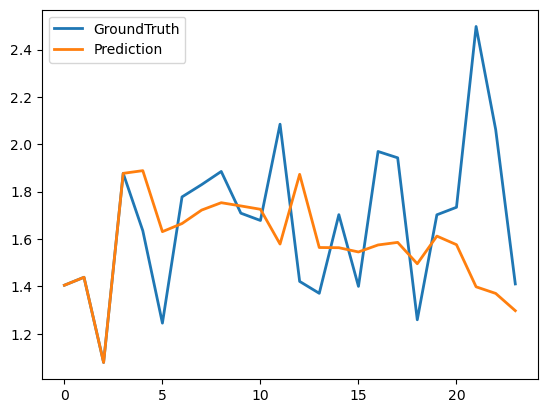

<Figure size 640x480 with 0 Axes>

In [5]:
%matplotlib inline
#visualisation of the scaled test results during training
plt.figure()

In [6]:
args.do_predict = True
if args.do_predict:
    print('>>>>>>>predicting : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    prediction=exp.predict(setting, True)#data_factory做好了pred里面的batch_size=1的情况，是autoformer在informer基础之上做的
    torch.cuda.empty_cache()
    # print(prediction.shape)
%matplotlib inline

2024-09-11:21:35:20,972 INFO     [exp_main.py:249] ./checkpoints/resale_24_12_Autoformer_custom_ftM_sl4_ll2_pl20_dm4096_nh8_el3_dl2_df16384_fc1_ebtimeF_dtTrue_Exp_0/checkpoint.pth


>>>>>>>predicting : resale_24_12_Autoformer_custom_ftM_sl4_ll2_pl20_dm4096_nh8_el3_dl2_df16384_fc1_ebtimeF_dtTrue_Exp_0<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
pred 1


In [7]:
data_pred = np.load('./results/{}/real_prediction.npy'.format(setting)).squeeze()
data_gt = pd.read_csv('./dataset/resale_price/resale_price_AF_test.csv').to_numpy()[:,1:].astype('float32')

In [8]:
#mse for each row
col_names=pd.read_csv('./dataset/resale_price/resale_price_AF_test.csv').columns[1:]
rmse_m=np.sqrt(np.mean((data_gt-data_pred)**2,axis=0))
mape_m=np.mean(np.abs((data_gt-data_pred) / data_gt),axis=0)
pd.DataFrame(rmse_m.reshape(1,-1),columns=col_names)

,resale_price_BUKIT TIMAH,resale_price_YISHUN,resale_price_WOODLANDS,resale_price_TOA PAYOH,resale_price_PUNGGOL,resale_price_KALLANG/WHAMPOA,resale_price_CLEMENTI,resale_price_ANG MO KIO,resale_price_BUKIT BATOK,resale_price_BEDOK,...,resale_price_SEMBAWANG,resale_price_BUKIT MERAH,resale_price_SENGKANG,resale_price_BISHAN,resale_price_TAMPINES,resale_price_BUKIT PANJANG,resale_price_JURONG EAST,resale_price_CENTRAL AREA,resale_price_SERANGOON,resale_price_GEYLANG
0,141777.421875,27554.636719,33838.753906,41362.0625,31640.445312,61011.402344,38744.902344,31967.849609,23984.398438,27575.193359,...,28527.361328,48166.128906,26288.298828,58085.730469,36395.910156,29730.070312,31568.490234,88565.5,54966.664062,56700.347656


In [9]:
pd.DataFrame(mape_m.reshape(1,-1),columns=col_names)

,resale_price_BUKIT TIMAH,resale_price_YISHUN,resale_price_WOODLANDS,resale_price_TOA PAYOH,resale_price_PUNGGOL,resale_price_KALLANG/WHAMPOA,resale_price_CLEMENTI,resale_price_ANG MO KIO,resale_price_BUKIT BATOK,resale_price_BEDOK,...,resale_price_SEMBAWANG,resale_price_BUKIT MERAH,resale_price_SENGKANG,resale_price_BISHAN,resale_price_TAMPINES,resale_price_BUKIT PANJANG,resale_price_JURONG EAST,resale_price_CENTRAL AREA,resale_price_SERANGOON,resale_price_GEYLANG
0,0.146627,0.041816,0.050395,0.061289,0.040769,0.08235,0.05189,0.046553,0.034973,0.04211,...,0.046463,0.057108,0.036293,0.046469,0.049492,0.039686,0.051343,0.109377,0.071142,0.081476


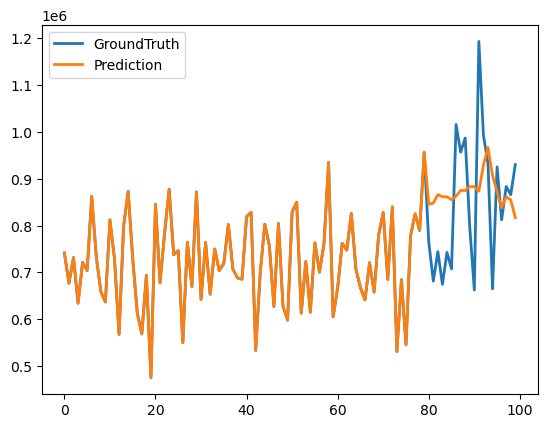

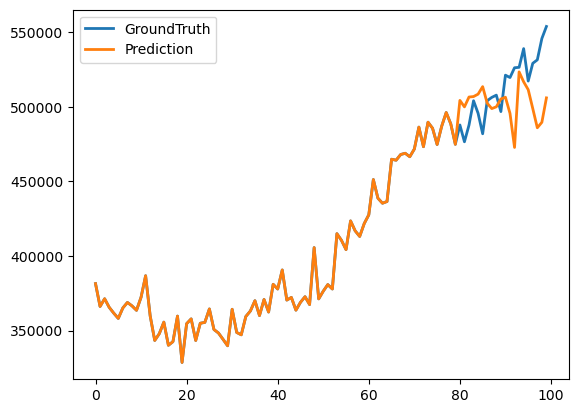

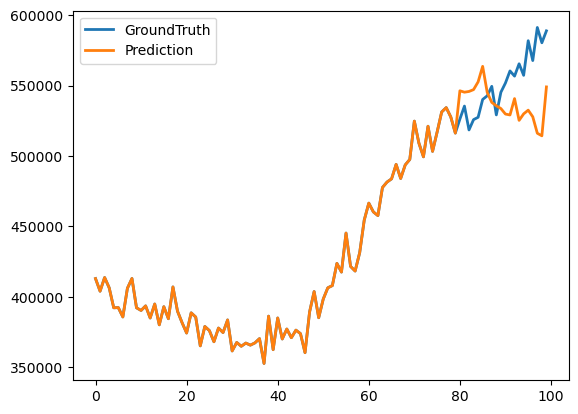

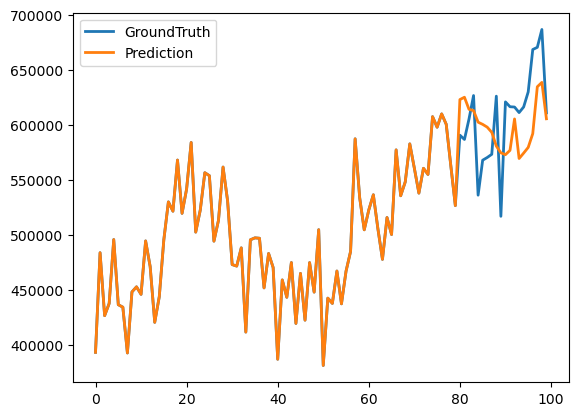

In [11]:
#visulization
true = np.concatenate([df.iloc[:,1:].values, data_gt], axis=0)
preds = np.concatenate([df.iloc[:,1:].values, data_pred], axis=0)

plt.figure()
plt.plot(true[-100:,0], label='GroundTruth', linewidth=2)
plt.plot(preds[-100:,0], label='Prediction', linewidth=2)
plt.legend()

plt.figure()
plt.plot(true[-100:,1], label='GroundTruth', linewidth=2)
plt.plot(preds[-100:,1], label='Prediction', linewidth=2)
plt.legend()

plt.figure()
plt.plot(true[-100:,2], label='GroundTruth', linewidth=2)
plt.plot(preds[-100:,2], label='Prediction', linewidth=2)
plt.legend()

plt.figure()
plt.plot(true[-100:,3], label='GroundTruth', linewidth=2)
plt.plot(preds[-100:,3], label='Prediction', linewidth=2)
plt.legend()